# Shapley Value Attribution for Sequential (LSTM) Models

This document presents a rigorous treatment of Shapley value attributions applied to Long Short-Term Memory (LSTM) neural networks. We elucidate the theoretical foundations, derive the formal definition for sequence data, describe unbiased Monte Carlo estimation of ground-truth values, and explain the adaptation of the SHAP DeepExplainer. Finally, we outline a methodology for comparative visualization and discuss the implications of interpretability in sequential models.

## 1. Introduction
Interpreting the contributions of individual inputs to a model’s prediction is critical for transparency in machine learning. While Shapley values are well established for static, tabular data, sequence models such as LSTMs pose a conceptual extension: each input element appears in temporal context. We treat each time–feature pair as an independent “player” in the Shapley game, enabling fair attribution across the entire sequence.

## 2. Formal Definition for Sequence Attributions

Let:

- $T$ denote the length of the input sequence  
- $F$ the feature dimension at each time step  
- $N_{\text{seq}} = \{(t, i) : t = 1, \dots, T;\ i = 1, \dots, F \}$ the set of all time–feature pairs  
- $x \in \mathbb{R}^{T \times F}$ a specific input sequence  
- $f : \mathbb{R}^{T \times F} \to \mathbb{R}$ the model’s scalar output  
- $b \in \mathbb{R}^{T \times F}$ the baseline sequence (e.g., empirical mean over reference set)

For any coalition $S \subseteq N_{\text{seq}}$, define the masked sequence $x_S$ by:

$$
x_S[t, i] =
\begin{cases}
x[t, i], & \text{if } (t, i) \in S \\
b[t, i], & \text{otherwise}
\end{cases}
$$

The Shapley value for the cell $(t, i)$ is:

$$
\phi_{t, i} =
\sum_{S \subseteq N_{\text{seq}} \setminus \{(t, i)\}}
\frac{|S|! \cdot (|N_{\text{seq}}| - |S| - 1)!}{|N_{\text{seq}}|!}
\left[ f(x_{S \cup \{(t, i)\}}) - f(x_S) \right]
$$

This ensures fair attribution across all possible input combinations and satisfies the axioms of efficiency, symmetry, nullity, and additivity.

## 3. Unbiased Monte Carlo Estimation

The exact summation spans $2^{T \cdot F}$ coalitions, which becomes intractable. We instead use a Monte Carlo estimator:

1. For each $(t, i)$ and $m = 1, \dots, M$, sample $S_m \subseteq N_{\text{seq}} \setminus \{(t, i)\}$ by including each other cell independently with probability 0.5  
2. Compute marginal contributions:  
   $$
   d_m = f(x_{S_m \cup \{(t, i)\}}) - f(x_{S_m})
   $$
3. Estimate:  
   $$
   \phi_{t, i}^{\text{MC}} \approx \frac{1}{M} \sum_{m=1}^M d_m
   $$

By the law of large numbers, $\phi_{t, i}^{\text{MC}} \to \phi_{t, i}$ as $M \to \infty$.

## 4. SHAP DeepExplainer Adaptation

SHAP DeepExplainer uses a background set $X_b = \{x'^{(1)}, \dots, x'^{(K)}\}$ to estimate:

$$
\mathbb{E}_{x' \sim X_b}[f(x')] \approx \frac{1}{K} \sum_{k=1}^K f(x'^{(k)})
$$

Then it computes attributions $\psi_{t, i}(x)$ satisfying:

$$
f(x) = \mathbb{E}[f(x')] + \sum_{t=1}^T \sum_{i=1}^F \psi_{t, i}(x)
$$

Nonlinear recurrent operations are linearized via Taylor expansion around each background sample, and backpropagation aggregates the contributions. For LSTM internals, `check_additivity=False` can be set to disable exact-sum checking if the model structure leads to slight mismatches.

## 5. Comparative Visualization Method

To compare $\phi^{\text{MC}}$ and $\psi$, we reshape both into $T \times F$ matrices and visualize using 3D bar charts:

- **Axes:** time index $t$, feature index $i$, attribution magnitude  
- **Left Plot:** Monte Carlo estimate $\phi_{t, i}^{\text{MC}}$  
- **Right Plot:** SHAP DeepExplainer attribution $\psi_{t, i}$

A close match between surfaces indicates high fidelity of the approximation.

## 6. Discussion and Conclusion

This exposition extends Shapley values to sequential models by treating time–feature positions as individual contributors. Monte Carlo sampling yields unbiased attributions, while DeepExplainer offers efficient, differentiable approximations. Visualization of attribution surfaces enables interpretation of temporal dynamics and helps validate explainer reliability.


/home/niyang/repos/enhanced_shap/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[SurroSHAP] Computing SHAP attributions for background data...
  10/50 attributions done...
  20/50 attributions done...
  30/50 attributions done...
  40/50 attributions done...
  50/50 attributions done...
[SurroSHAP] Training surrogate regression model...
[SurroSHAP] Surrogate trained.
Running Deep...
Running Gradient...
Running SurroSHAP...


/home/niyang/repos/enhanced_shap/.venv/lib64/python3.13/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


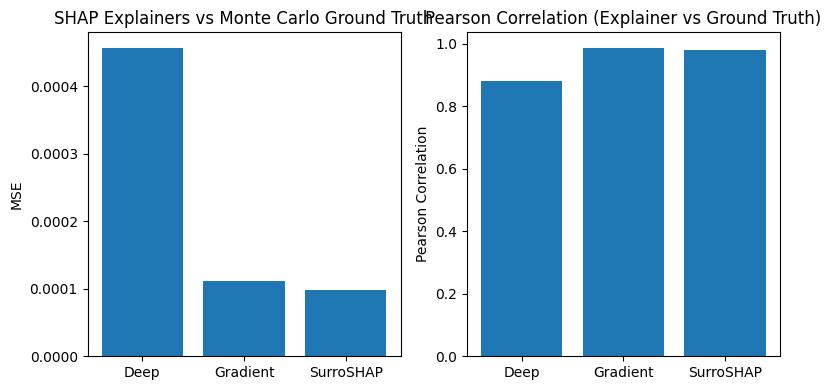

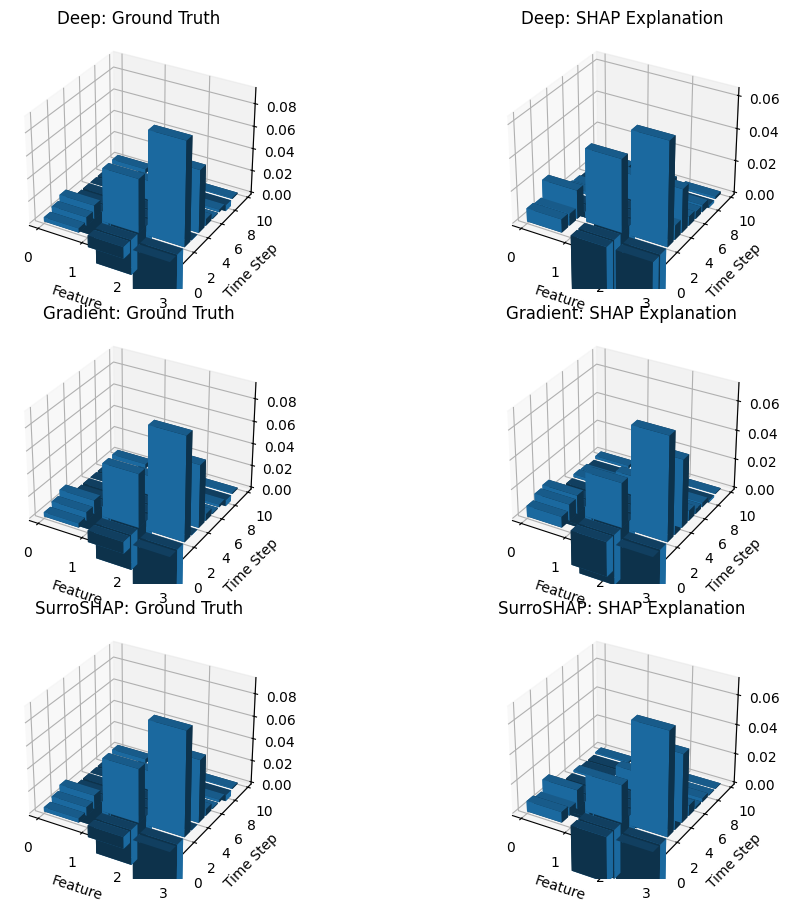

In [1]:
import torch
import shap

from shap_enhanced.tools.predefined_models import RealisticLSTM
from shap_enhanced.tools.datasets import generate_synthetic_seqregression
from shap_enhanced.tools.evaluation import compute_shapley_gt
from shap_enhanced.tools.comparison import Comparison
from shap_enhanced.tools.visulization import plot_mse_pearson, plot_3d_bars

from shap_enhanced.explainers.CASHAP import CoalitionAwareSHAPExplainer
from shap_enhanced.explainers.AttnSHAP import AttnSHAPExplainer
from shap_enhanced.explainers.BSHAP import BShapExplainer
from shap_enhanced.explainers.CMSHAP import ContextualMaskingSHAPExplainer
from shap_enhanced.explainers.ESSHAP import EnsembleSHAPWithNoise
from shap_enhanced.explainers.SurroSHAP import SurrogateSHAPExplainer

# 1. Generate synthetic sequential data
seq_len, n_features, n_samples = 10, 3, 200
X, y = generate_synthetic_seqregression(seq_len, n_features, n_samples)

# 2. Train the LSTM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RealisticLSTM(input_dim=n_features).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

X_t = torch.tensor(X, dtype=torch.float32).to(device)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

model.train()
for epoch in range(100):
    opt.zero_grad()
    loss = loss_fn(model(X_t), y_t)
    loss.backward()
    opt.step()

# 3. Pick a test sample and a baseline
x_test = X[0]
x_baseline = X.mean(0)

# 4. Compute Monte Carlo ground-truth SHAP values
shap_gt = compute_shapley_gt(model, x_test, x_baseline, nsamples=200, device=device)

# 5. Define SHAP input functions
def f_numpy(flat_x):
    x = flat_x.reshape(-1, seq_len, n_features)
    with torch.no_grad():
        return model(torch.tensor(x, dtype=torch.float32).to(device)).cpu().numpy()

bg_flat = X[:50].reshape(50, -1)
background_pt = torch.tensor(X[:50], dtype=torch.float32).to(device)

# 6. Instantiate explainers
bshap_domain = (X[:50].min(axis=0), X[:50].max(axis=0))  # for 'uniform'
# Or: bshap_domain = X[:50]                             # for 'marginal'

explainers = {
    "Deep":      shap.DeepExplainer(model, background_pt),
    "Gradient":  shap.GradientExplainer(model, background_pt),
    # "Kernel":    shap.KernelExplainer(f_numpy, bg_flat),
    # "Partition": shap.PartitionExplainer(f_numpy, bg_flat),
    # "CASHAP":    CoalitionAwareSHAPExplainer(
    #     model=model, 
    #     background=X[:50],
    #     mask_strategy="mean",
    #     device=device
    # ),
    # "AttnSHAP":  AttnSHAPExplainer(
    #     model=model,
    #     background=X[:50],
    #     use_attention=True,
    #     proxy_attention="gradient",
    #     device=device
    # ),
    # "BShap":     BShapExplainer(
    #     model=model,
    #     input_range=(X.min(), X.max()),  # Or per-feature: (X.min(axis=0), X.max(axis=0))
    #     n_samples=30,
    #     mask_strategy="random",          # 'random' (default), 'noise', or 'zero'
    #     device=device
    # ),
    # "CM-SHAP":   ContextualMaskingSHAPExplainer(
    #     model=model,
    #     device=device
    # ),
    # "Ensemble-Deep": EnsembleSHAPWithNoise(
    #     model=model,
    #     background=X[:50],           # Must be torch.Tensor or np.ndarray as fits explainer
    #     explainer_class=None,        # Defaults to shap.DeepExplainer
    #     explainer_kwargs={},
    #     n_runs=5,
    #     noise_level=0.1,
    #     noise_target="input",        # Or "background" or "both"
    #     aggregation="mean",
    #     device=device
    # ),
    "SurroSHAP": SurrogateSHAPExplainer(
        model=model,
        background=X[:50],
        base_explainer=shap.GradientExplainer(model, background_pt),
    ),
}


def reshape_shap_arr(arr):
    return arr.reshape(seq_len, n_features)

# 7. Compute SHAP values for each explainer
shap_models = {}
for name, expl in explainers.items():
    print(f"Running {name}...")
    if name in ["Deep", "Gradient"]:
        inp = torch.tensor(x_test[None], dtype=torch.float32, requires_grad=True).to(device)
        if name == "Deep":
            raw = expl.shap_values(inp, check_additivity=False)
        else:
            raw = expl.shap_values(inp)
        if isinstance(raw, list):
            raw = raw[0]
        arr = reshape_shap_arr(raw)
    # elif name == "Kernel":
    #     raw = expl.shap_values(x_test.reshape(1, -1))
    #     arr = reshape_shap_arr(raw)
    # elif name == "Partition":
    #     out = expl(x_test.reshape(1, -1))
    #     arr = reshape_shap_arr(out.values[0])
    # elif name in ["CASHAP", "AttnSHAP"]:
    #     arr = expl.shap_values(x_test, nsamples=20, coalition_size=6)
    # elif name == "BShap":
    #     arr = expl.shap_values(x_test, check_additivity=True)
    # elif name == "CM-SHAP":
    #     arr = expl.shap_values(x_test, nsamples=20, check_additivity=True)
    # elif name == "Ensemble-Deep":
    #     arr = expl.shap_values(inp, check_additivity=False)
    #     arr = reshape_shap_arr(arr)
    elif name == "SurroSHAP":
        arr = expl.shap_values(x_test)
        arr = reshape_shap_arr(arr)
    else:
        raise NotImplementedError(f"Unknown explainer: {name}")
    shap_models[name] = arr

# 8. KPI comparison (MSE & Pearson)
cmp = Comparison(ground_truth=shap_gt, shap_models=shap_models)
results, pearson_results = cmp.calculate_kpis()

# 9. Visualize KPIs and 3D bars
plot_mse_pearson(results, pearson_results)
plot_3d_bars(shap_gt, shap_models, seq_len, n_features)